Cell 1: Initial Setup with SeisBench Download

In [ ]:
# -*- coding: utf-8 -*-
"""
Seismogram_Based_MO_INSTANCE_Preprocessing.ipynb

This notebook processes the INSTANCE dataset for seismogram-based splitting,
which treats each seismogram as an independent sample.
"""

# Install and import required packages
!pip install seisbench
!pip install torch torchvision torchaudio
!pip install h5py pandas tqdm matplotlib torchinfo seaborn

from google.colab import drive
import time
import os
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import torch
from collections import defaultdict
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import seisbench.data as sbd

# Start time
start_time = time.time()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Mount Google Drive for output directory only
drive.mount('/content/drive')

# Set SeisBench to use local VM storage to avoid quota issues
os.environ['SEISBENCH_CACHE_ROOT'] = '/content/.seisbench'
print(f"SeisBench cache root: {os.environ['SEISBENCH_CACHE_ROOT']}")

# Download INSTANCE dataset using SeisBench
print("Downloading INSTANCE dataset using SeisBench...")
print("This will download to local VM storage, avoiding Google Drive quota issues...")
instance = sbd.InstanceCounts()

# Get paths to the downloaded files
instance_path = instance.path
metadata_path = os.path.join(instance_path, "metadata.csv")
hdf5_path = os.path.join(instance_path, "waveforms.hdf5")

# Output directory for seismogram-based results
output_dir = "/content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/INSTANCE_Seismogram_Based/Upper_Half_EpiDis"
os.makedirs(output_dir, exist_ok=True)

# Verify files exist
print(f"INSTANCE dataset path: {instance_path}")
print(f"Files in INSTANCE dataset folder:")
print(os.listdir(instance_path))

assert os.path.isfile(metadata_path), f"Metadata file not found at {metadata_path}"
assert os.path.isfile(hdf5_path), f"HDF5 file not found at {hdf5_path}"

print(f"✓ Using SeisBench INSTANCE files:")
print(f"  Metadata: {metadata_path}")
print(f"  HDF5: {hdf5_path}")
print(f"✓ Output directory: {output_dir}")

Using device: cpu
Mounted at /content/drive
SeisBench cache root: /content/.seisbench
This will download to local VM storage, avoiding Google Drive quota issues...


2025-08-25 13:43:16,303 | seisbench | WARNING | Dataset InstanceCounts not in cache.
2025-08-25 13:43:16,305 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.
2025-08-25 16:02:08,073 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


INSTANCE dataset path: /root/.seisbench/datasets/instancecounts
Files in INSTANCE dataset folder:
['metadata.csv', 'waveforms.hdf5']
✓ Using SeisBench INSTANCE files:
  Metadata: /root/.seisbench/datasets/instancecounts/metadata.csv
  HDF5: /root/.seisbench/datasets/instancecounts/waveforms.hdf5
✓ Output directory: /content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/INSTANCE_Seismogram_Based/Upper_Half_EpiDis


Cell 2: Data Loading and Initial Filtering

Initial number of metadata entries: 1159249


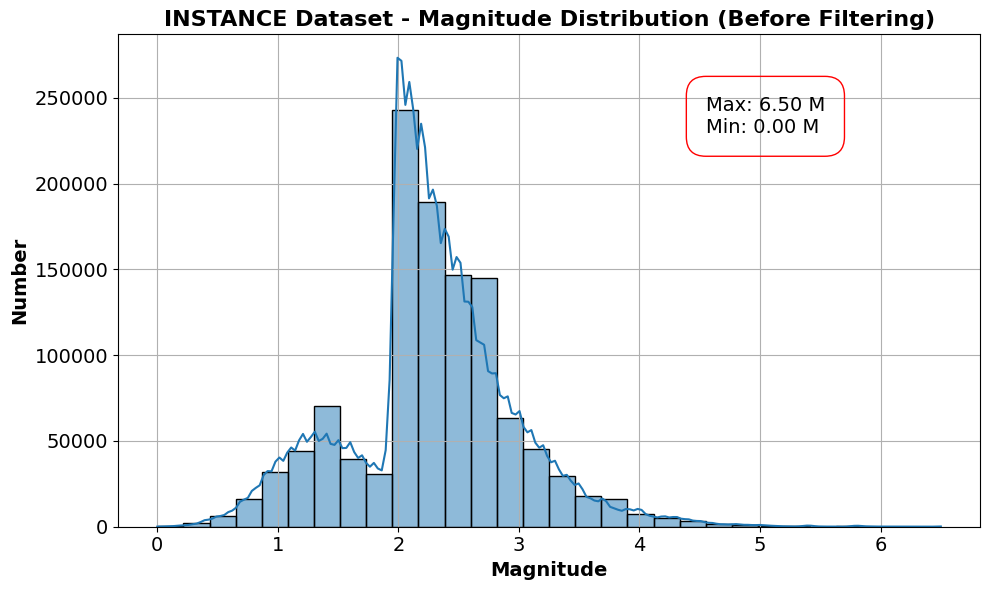

Number of metadata entries now: 1159249


In [ ]:
"""Cell 2: Data Loading and Initial Filtering"""

# Load and access the metadata from the CSV file
metadata = pd.read_csv(metadata_path, low_memory=False)
print(f"Initial number of metadata entries: {len(metadata)}")

# Ensure the 'source_origin_time' column is in datetime format
metadata['source_origin_time'] = pd.to_datetime(metadata['source_origin_time'])

# Sort by source_origin_time to ensure chronological order
metadata = metadata.sort_values(by='source_origin_time')

#================No need to filter by date from September 2018 onwards since we want all data================
# # Filter metadata for dates from September 2018 onwards
# from datetime import datetime, timezone
# start_date = datetime(2018, 9, 1, tzinfo=timezone.utc)
# metadata = metadata[metadata['source_origin_time'] >= start_date]
# print(f"Number of metadata entries from 1st September 2018 to 31st January 2020: {len(metadata)}")
#=============================================================================================================

# Plot the histogram of the earthquake magnitudes before filtering
plt.figure(figsize=(10, 6))
sns.histplot(metadata["source_magnitude"], bins=30, kde=True)
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = metadata["source_magnitude"].max()
min_magnitude = metadata["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.title('INSTANCE Dataset - Magnitude Distribution (Before Filtering)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

print(f"Number of metadata entries now: {len(metadata)}")

Cell 3: Apply Data Filtering Criteria

In [ ]:
"""Cell 3: Apply Data Filtering Criteria"""

import copy

# Create a deep copy of the metadata
filtered_metadata = copy.deepcopy(metadata)

# Set sampling rate
filtered_metadata['trace_sampling_rate_hz'] = 100

# Filtering for INSTANCE dataset within 30s window
filters = [
    ('path_ep_distance_km <= 110', filtered_metadata.path_ep_distance_km <= 110),
    ('source_magnitude_type == ML', filtered_metadata.source_magnitude_type == 'ML'),
    ('trace_P_arrival_sample.notnull()', filtered_metadata.trace_P_arrival_sample.notnull()),
    ('path_travel_time_P_s.notnull()', filtered_metadata.path_travel_time_P_s.notnull()),
    ('path_travel_time_P_s > 0', filtered_metadata.path_travel_time_P_s > 0),
    ('path_ep_distance_km.notnull()', filtered_metadata.path_ep_distance_km.notnull()),
    ('path_ep_distance_km > 28.66', filtered_metadata.path_ep_distance_km > 28.66),
    ('source_depth_km.notnull()', filtered_metadata.source_depth_km.notnull()),
    ('source_magnitude.notnull()', filtered_metadata.source_magnitude.notnull()),
    ('path_backazimuth_deg.notnull()', filtered_metadata.path_backazimuth_deg.notnull()),
    ('path_backazimuth_deg > 0', filtered_metadata.path_backazimuth_deg > 0),
]

# Apply filters one by one and keep track of the data
for desc, filt in filters:
    filtered_metadata = filtered_metadata[filt]
    print(f"After filter '{desc}': {len(filtered_metadata)} entries")

# Ensure at least 30 seconds of data after P-arrival
filtered_metadata = filtered_metadata[filtered_metadata.trace_P_arrival_sample + filtered_metadata.trace_sampling_rate_hz * 30 <= filtered_metadata.trace_npts]
print(f"After ensuring 30s after P arrival: {len(filtered_metadata)} entries")

# Calculate time window statistics
filtered_metadata['window_start'] = filtered_metadata.trace_P_arrival_sample - filtered_metadata.trace_sampling_rate_hz * 5  # 5 seconds before P arrival
filtered_metadata['window_end'] = filtered_metadata.trace_P_arrival_sample + filtered_metadata.trace_sampling_rate_hz * 25  # 25 seconds after P arrival (total 30s window)

# Ensure window start is not negative
filtered_metadata = filtered_metadata[filtered_metadata.window_start >= 0]
print(f"After ensuring non-negative window start: {len(filtered_metadata)} entries")

print(f"\nFinal number of filtered metadata entries: {len(filtered_metadata)}")

After filter 'path_ep_distance_km <= 110': 1010113 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_magnitude_type == ML': 979936 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'trace_P_arrival_sample.notnull()': 979936 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_travel_time_P_s.notnull()': 979936 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_travel_time_P_s > 0': 979936 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_ep_distance_km.notnull()': 979936 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_ep_distance_km > 28.66': 628693 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_depth_km.notnull()': 628693 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_magnitude.notnull()': 628693 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_backazimuth_deg.notnull()': 628693 entries


/tmp/ipython-input-1571596418.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_backazimuth_deg > 0': 628589 entries
After ensuring 30s after P arrival: 628587 entries
After ensuring non-negative window start: 628586 entries

Final number of filtered metadata entries: 628586


Cell 4: Apply SNR Filter and Multi-Observations

Number of records after SNR filtering: 203584


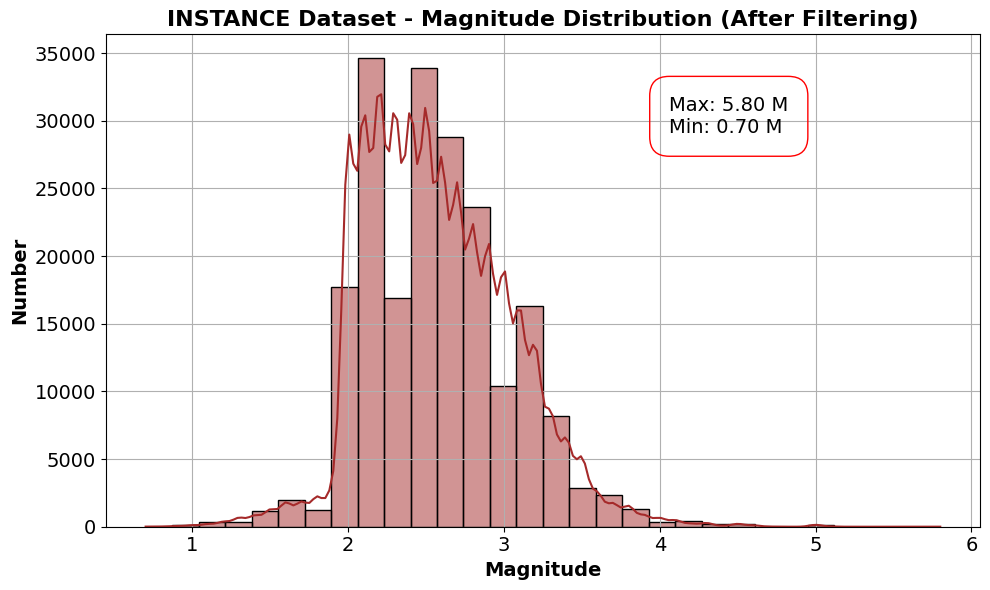

Filtering for multi-observations stations...
Counting observations per station...


  1%|          | 4/559 [00:00<00:14, 38.65it/s]

CING: 2776 observations
BADI: 625 observations
MURB: 2803 observations
MIDA: 643 observations
VAGA: 581 observations


  1%|▏         | 8/559 [00:00<00:14, 39.00it/s]

INTR: 1579 observations
GUAR: 467 observations


  2%|▏         | 12/559 [00:00<00:13, 39.18it/s]

FAGN: 2117 observations
GRI: 516 observations
VVLD: 634 observations
FIAM: 3405 observations
CERT: 1049 observations
SFI: 471 observations


  3%|▎         | 16/559 [00:00<00:13, 39.41it/s]

MNS: 580 observations


  4%|▍         | 25/559 [00:00<00:13, 39.62it/s]

TERO: 8559 observations
SACS: 468 observations
CAMP: 1361 observations


  7%|▋         | 37/559 [00:00<00:13, 39.58it/s]

RNI2: 504 observations
VLC: 415 observations
AQU: 645 observations
CEL: 604 observations


  9%|▉         | 53/559 [00:01<00:12, 39.45it/s]

GIB: 464 observations
MGR: 608 observations


 12%|█▏        | 67/559 [00:01<00:12, 39.75it/s]

CUC: 500 observations
BDI: 1135 observations
VCEL: 2622 observations
ARVD: 1986 observations
PLAC: 477 observations


 15%|█▍        | 83/559 [00:02<00:12, 39.41it/s]

SCHR: 400 observations
MSAG: 676 observations
OFFI: 1540 observations


 17%|█▋        | 95/559 [00:02<00:11, 39.15it/s]

CERA: 564 observations
SIRI: 1259 observations
MTSN: 410 observations
JOPP: 992 observations
MCEL: 609 observations
GALF: 664 observations


 19%|█▉        | 107/559 [00:02<00:11, 39.32it/s]

BULG: 419 observations
CRMI: 462 observations
POFI: 532 observations
SSY: 708 observations


 21%|██▏       | 119/559 [00:03<00:11, 39.39it/s]

MSRU: 679 observations
IVPL: 511 observations


 23%|██▎       | 131/559 [00:03<00:10, 39.44it/s]

PIEI: 1509 observations
CAFI: 978 observations
FSSB: 1415 observations
CESI: 2640 observations


 26%|██▌       | 143/559 [00:03<00:10, 39.36it/s]

LNSS: 2292 observations
FDMO: 2444 observations
MGAB: 2796 observations
PARC: 522 observations
LPEL: 973 observations


 28%|██▊       | 155/559 [00:03<00:10, 39.37it/s]

MTCE: 430 observations
CESX: 2191 observations
ASSB: 1994 observations
GUMA: 3588 observations


 30%|███       | 168/559 [00:04<00:09, 39.41it/s]

NRCA: 4310 observations


 35%|███▌      | 197/559 [00:04<00:09, 39.64it/s]

ROVR: 434 observations
SMA1: 1813 observations
SALB: 527 observations
SNTG: 3748 observations


 40%|███▉      | 221/559 [00:05<00:08, 39.49it/s]

ATVO: 692 observations
ATPC: 561 observations
ATFO: 773 observations
ATPI: 553 observations
CAR1: 563 observations


 41%|████      | 229/559 [00:05<00:08, 39.33it/s]

HLNI: 583 observations
NOV: 441 observations
RM33: 3870 observations


 44%|████▍     | 245/559 [00:06<00:07, 39.50it/s]

FRON: 1332 observations
MPNC: 579 observations
SSFR: 4444 observations
ATTE: 538 observations
MCSR: 473 observations


 45%|████▌     | 253/559 [00:06<00:07, 39.23it/s]

MUCR: 448 observations
CPGN: 407 observations
ATCC: 3567 observations


 47%|████▋     | 265/559 [00:06<00:07, 39.02it/s]

MPAG: 1162 observations
CET2: 606 observations


 50%|████▉     | 277/559 [00:07<00:07, 39.23it/s]

ARRO: 2238 observations


 53%|█████▎    | 294/559 [00:07<00:06, 39.60it/s]

ATMI: 645 observations
COR1: 497 observations


 55%|█████▍    | 307/559 [00:07<00:06, 39.80it/s]

MOMA: 2267 observations
FEMA: 512 observations
EL6: 4451 observations
CSP1: 3129 observations


 57%|█████▋    | 316/559 [00:08<00:06, 39.86it/s]

PE3: 578 observations


 59%|█████▊    | 328/559 [00:08<00:05, 39.73it/s]

FOSV: 2294 observations


 62%|██████▏   | 344/559 [00:08<00:05, 39.45it/s]

RUFI: 793 observations
MTCR: 641 observations


 64%|██████▎   | 356/559 [00:09<00:05, 39.36it/s]

ATLO: 487 observations
MNTP: 639 observations


 66%|██████▌   | 368/559 [00:09<00:04, 39.40it/s]

PP3: 481 observations


 69%|██████▊   | 384/559 [00:09<00:04, 39.58it/s]

SEF1: 442 observations


 71%|███████   | 396/559 [00:10<00:04, 39.27it/s]

T0110: 754 observations
GIGS: 579 observations
ATSC: 519 observations


 81%|████████  | 452/559 [00:11<00:02, 40.08it/s]

MC2: 972 observations
T1211: 5224 observations
T1243: 1978 observations
MMO1: 795 observations
T1241: 1347 observations
T1215: 3993 observations
T1216: 1472 observations
T1212: 1394 observations
T1213: 475 observations


 83%|████████▎ | 462/559 [00:11<00:02, 40.24it/s]

T1214: 1155 observations
T1244: 817 observations
T1246: 696 observations
T1247: 875 observations
T1299: 1694 observations
T1201: 471 observations
T1217: 2880 observations
T1218: 2264 observations


 84%|████████▍ | 472/559 [00:11<00:02, 40.22it/s]

T1204: 535 observations
T1245: 421 observations
T1220: 1600 observations
T1219: 2256 observations
T1221: 1494 observations


 86%|████████▌ | 482/559 [00:12<00:01, 39.74it/s]

T1222: 791 observations
MTRA: 499 observations


 88%|████████▊ | 494/559 [00:12<00:01, 39.34it/s]

MF5: 803 observations


100%|██████████| 559/559 [00:14<00:00, 39.41it/s]


Number of stations with ≥400 observations: 122
Number of records after multi-observations filtering: 164062

Seismogram-based approach: treating each of 164062 seismograms independently
Note: This approach allows seismograms from the same event to be in different splits


In [ ]:
"""Cell 4: Apply SNR Filter and Multi-Observations"""

# Process SNR - same as event-based
if 'snr_db' in filtered_metadata.columns:
    def string_convertor(dd):
        if isinstance(dd, str):
            dd2 = dd.split()
            SNR = []
            for d in dd2:
                if d not in ['[', ']']:
                    dL = d.split('[')
                    dR = d.split(']')
                    if len(dL) == 2:
                        dig = dL[1]
                    elif len(dR) == 2:
                        dig = dR[0]
                    elif len(dR) == 1 and len(dL) == 1:
                        dig = d
                    try:
                        dig = float(dig)
                    except Exception:
                        dig = None
                    SNR.append(dig)
            return np.mean([x for x in SNR if x is not None])
        else:
            return np.nan

    filtered_metadata['snr_db'] = filtered_metadata.snr_db.apply(string_convertor)
    filtered_metadata = filtered_metadata[filtered_metadata.snr_db >= 20]
else:
    # Use appropriate SNR columns from INSTANCE dataset
    snr_columns = ['trace_E_snr_db', 'trace_N_snr_db', 'trace_Z_snr_db']
    filtered_metadata['avg_snr_db'] = filtered_metadata[snr_columns].mean(axis=1)
    filtered_metadata = filtered_metadata[filtered_metadata.avg_snr_db >= 20]

print(f"Number of records after SNR filtering: {len(filtered_metadata)}")

# Plot the histogram of the earthquake magnitudes after filtering
plt.figure(figsize=(10, 6))
sns.histplot(filtered_metadata["source_magnitude"], bins=30, kde=True, color='brown')
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = filtered_metadata["source_magnitude"].max()
min_magnitude = filtered_metadata["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.title('INSTANCE Dataset - Magnitude Distribution (After Filtering)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

# Implementing multi-observations with a threshold of >= 400
print("Filtering for multi-observations stations...")
uniq_ins = filtered_metadata.station_code.unique()
labM = []

print("Counting observations per station...")
for station in tqdm(uniq_ins):
    count = sum(filtered_metadata.station_code == station)
    if count >= 400:
        labM.append(station)
        print(f"{station}: {count} observations")

print(f"Number of stations with ≥400 observations: {len(labM)}")

# Save the multi-observations stations list
multi_observations_path = os.path.join(output_dir, "multi_observations.npy")
np.save(multi_observations_path, labM)

# Filter the dataset to include only records from stations with ≥400 observations
df_filtered = filtered_metadata[filtered_metadata.station_code.isin(labM)]
print(f"Number of records after multi-observations filtering: {len(df_filtered)}")

# For seismogram-based splitting, we note event information but don't group by it
print(f"\nSeismogram-based approach: treating each of {len(df_filtered)} seismograms independently")
print(f"Note: This approach allows seismograms from the same event to be in different splits")

Plot the histogram of the earthquake path epicenter distance after filtering

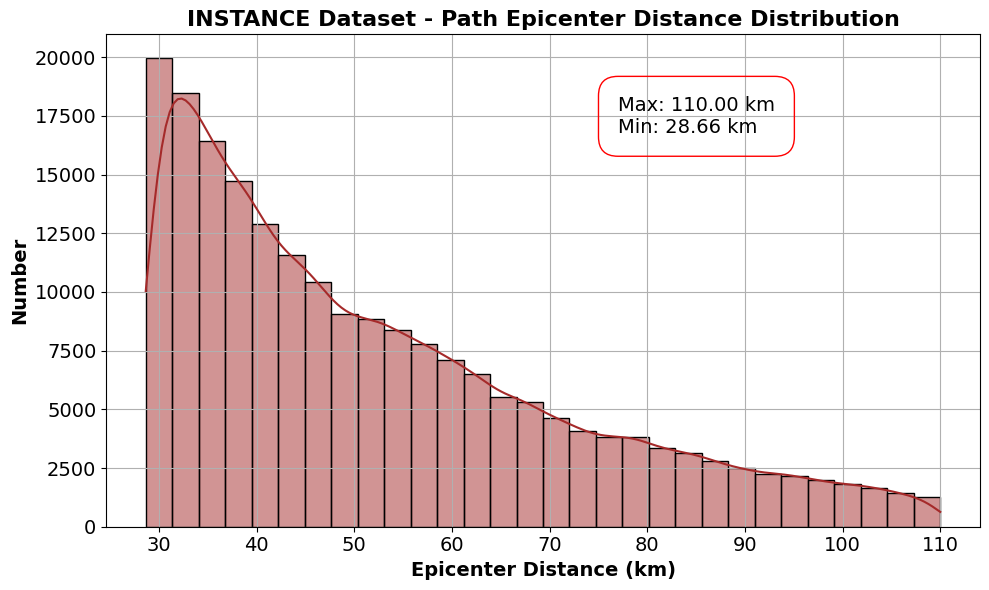

In [ ]:
# Plot the histogram of the earthquake path epicenter distance after filtering
plt.figure(figsize=(10, 6))
sns.histplot(filtered_metadata["path_ep_distance_km"], bins=30, kde=True, color='brown')
plt.xlabel('Epicenter Distance (km)', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_distance = filtered_metadata["path_ep_distance_km"].max()
min_distance = filtered_metadata["path_ep_distance_km"].min()
plt.text(0.7*max_distance, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_distance:.2f} km\nMin: {min_distance:.2f} km',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.title('INSTANCE Dataset - Path Epicenter Distance Distribution', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# # Calculate the median epicenter distance after filtering
# median_distance = filtered_metadata["path_ep_distance_km"].median()

# # Plot the histogram of the earthquake path epicenter distance after filtering
# plt.figure(figsize=(10, 6))
# sns.histplot(filtered_metadata["path_ep_distance_km"], bins=30, kde=True, color='brown')
# plt.xlabel('Epicenter Distance (km)', fontweight='bold', fontsize=14)
# plt.ylabel('Number', fontweight='bold', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=14)
# plt.grid(True)
# max_distance = filtered_metadata["path_ep_distance_km"].max()
# min_distance = filtered_metadata["path_ep_distance_km"].min()
# plt.text(0.7*max_distance, plt.gca().get_ylim()[1]*0.8,
#          f'Max: {max_distance:.2f} km\nMin: {min_distance:.2f} km',
#          bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)

# # Add a vertical line at the median epicenter distance
# plt.axvline(x=median_distance, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_distance:.2f} km')

# # INSTANCE dataset - Path Epicenter Distance Distribution after filtering
# plt.title('INSTANCE Dataset - Path Epicenter Distance Distribution', fontweight='bold', fontsize=16)
# plt.legend()
# plt.tight_layout()
# plt.show()

# print(f"The median epicenter distance is: {median_distance:.2f} km")

Cell 5: Data Loading Function

In [ ]:
"""Cell 5: Data Loading Function (Same as Event-Based)"""

# Function to load seismogram data from HDF5 file (same as event-based)
def load_seismogram_instance(hdf5_path, seismogram_id, metadata_row):
    """
    Load a single seismogram from the INSTANCE HDF5 file

    Args:
        hdf5_path: Path to the HDF5 file
        seismogram_id: ID of the seismogram to load (trace_name)
        metadata_row: Row from metadata containing trace information

    Returns:
        Tuple of (data, magnitude) or (None, None) if seismogram not found

    Notes:
        - Data is a 30-second window: 5s before P-arrival and 25s after
        - Resampled to 100Hz if necessary
    """
    try:
        with h5py.File(hdf5_path, 'r') as hdf:
            # Parse the trace name to get bucket and trace index
            bucket, trace_info = seismogram_id.split('$')
            trace_index = int(trace_info.split(',')[0])

            # Retrieve waveform data
            waveform = np.array(hdf['data'][bucket][trace_index])

            sampling_rate = metadata_row['trace_sampling_rate_hz']
            spt = int(metadata_row['trace_P_arrival_sample'])

            # Adjust window size based on sampling rate
            window_samples = int(30 * sampling_rate)  # 30 seconds window
            start = max(0, spt - int(5 * sampling_rate))  # 5 seconds before P arrival
            end = start + window_samples

            if start >= waveform.shape[1] or end > waveform.shape[1]:
                print(f"Skipping event {seismogram_id}: Invalid window")
                return None, None

            dshort = waveform[:, start:end]

            # Ensure the shape is correct
            if dshort.shape[1] != window_samples:
                print(f"Skipping event {seismogram_id}: Incorrect window size")
                return None, None

            # Resample to 100 Hz if necessary
            if sampling_rate != 100:
                dshort = scipy.signal.resample(dshort, 3000, axis=1)

            mag = round(float(metadata_row['source_magnitude']), 2)

            return dshort, mag

    except Exception as e:
        print(f"Error processing event {seismogram_id}: {e}")
        return None, None

Cell 6: Load All Seismograms (Simplified - No Event Grouping)

In [ ]:
"""Cell 6: Load All Seismograms (Simplified for Seismogram-Based)"""

# Load all valid seismograms - simpler than event-based since no grouping needed
print("Loading all valid seismograms for seismogram-based splitting...")
all_data = []
all_labels = []
all_seismogram_ids = []

# Create a lookup dictionary for metadata rows
metadata_lookup = {row['trace_name']: row for _, row in df_filtered.iterrows()}

# Get list of all valid seismogram IDs
valid_seismogram_ids = df_filtered['trace_name'].tolist()
print(f"Number of seismograms to load: {len(valid_seismogram_ids)}")

# Load seismograms with progress tracking
for seis_id in tqdm(valid_seismogram_ids, desc="Loading seismograms"):
    if seis_id not in metadata_lookup:
        continue

    metadata_row = metadata_lookup[seis_id]
    data, label = load_seismogram_instance(hdf5_path, seis_id, metadata_row)

    if data is None:
        continue

    all_data.append(data)
    all_labels.append(label)
    all_seismogram_ids.append(seis_id)

# Convert lists to numpy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)
all_seismogram_ids = np.array(all_seismogram_ids)

print(f"Final dataset: {len(all_data)} seismograms")
print(f"Data shape: {all_data.shape}, Labels shape: {all_labels.shape}")

# For comparison with event-based approach
unique_events = df_filtered['source_id'].nunique() if 'source_id' in df_filtered.columns else df_filtered['source_event_id'].nunique()
avg_seismograms_per_event = len(all_data) / unique_events
print(f"Average seismograms per event: {avg_seismograms_per_event:.2f}")
print(f"Note: In seismogram-based splitting, these {len(all_data)} seismograms will be split randomly")
print(f"      regardless of which event they belong to, potentially causing data leakage.")

# Save seismogram IDs mapping
with open(os.path.join(output_dir, 'seismogram_indices.pkl'), 'wb') as f:
    pickle.dump({
        'seismogram_ids': all_seismogram_ids,
    }, f)

Loading all valid seismograms for seismogram-based splitting...
Number of seismograms to load: 164062


Loading seismograms: 100%|██████████| 164062/164062 [04:31<00:00, 603.28it/s] 


Final dataset: 164062 seismograms
Data shape: (164062, 3, 3000), Labels shape: (164062,)
Average seismograms per event: 7.54
Note: In seismogram-based splitting, these 164062 seismograms will be split randomly
      regardless of which event they belong to, potentially causing data leakage.


Cell 7: Visualize Sample Seismograms

Plotting example seismograms for seismogram-based approach:

Example 1:


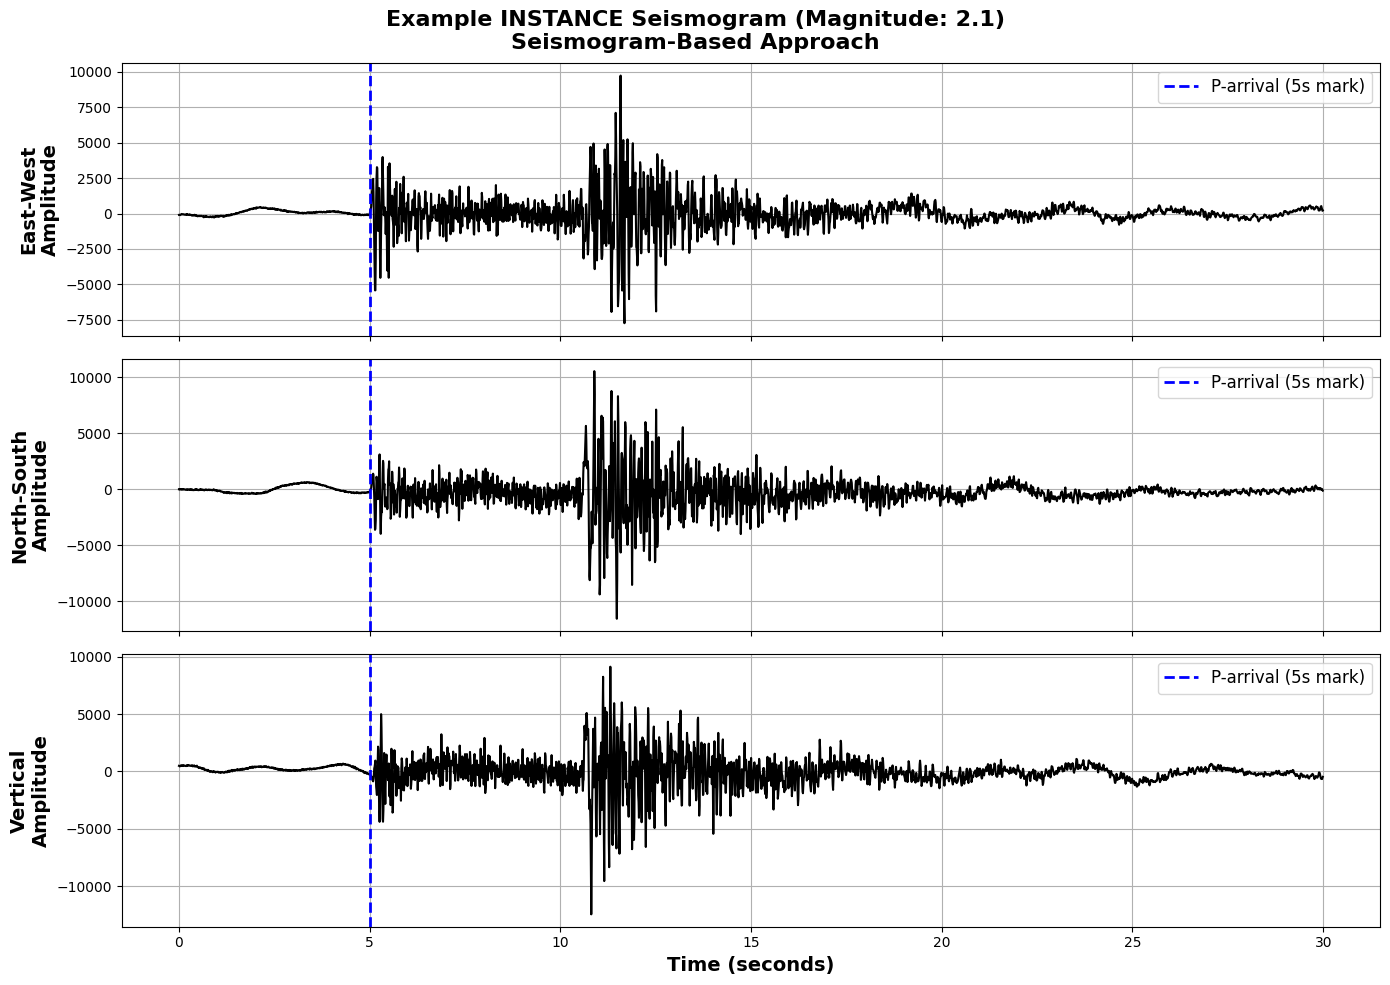


Example 101:


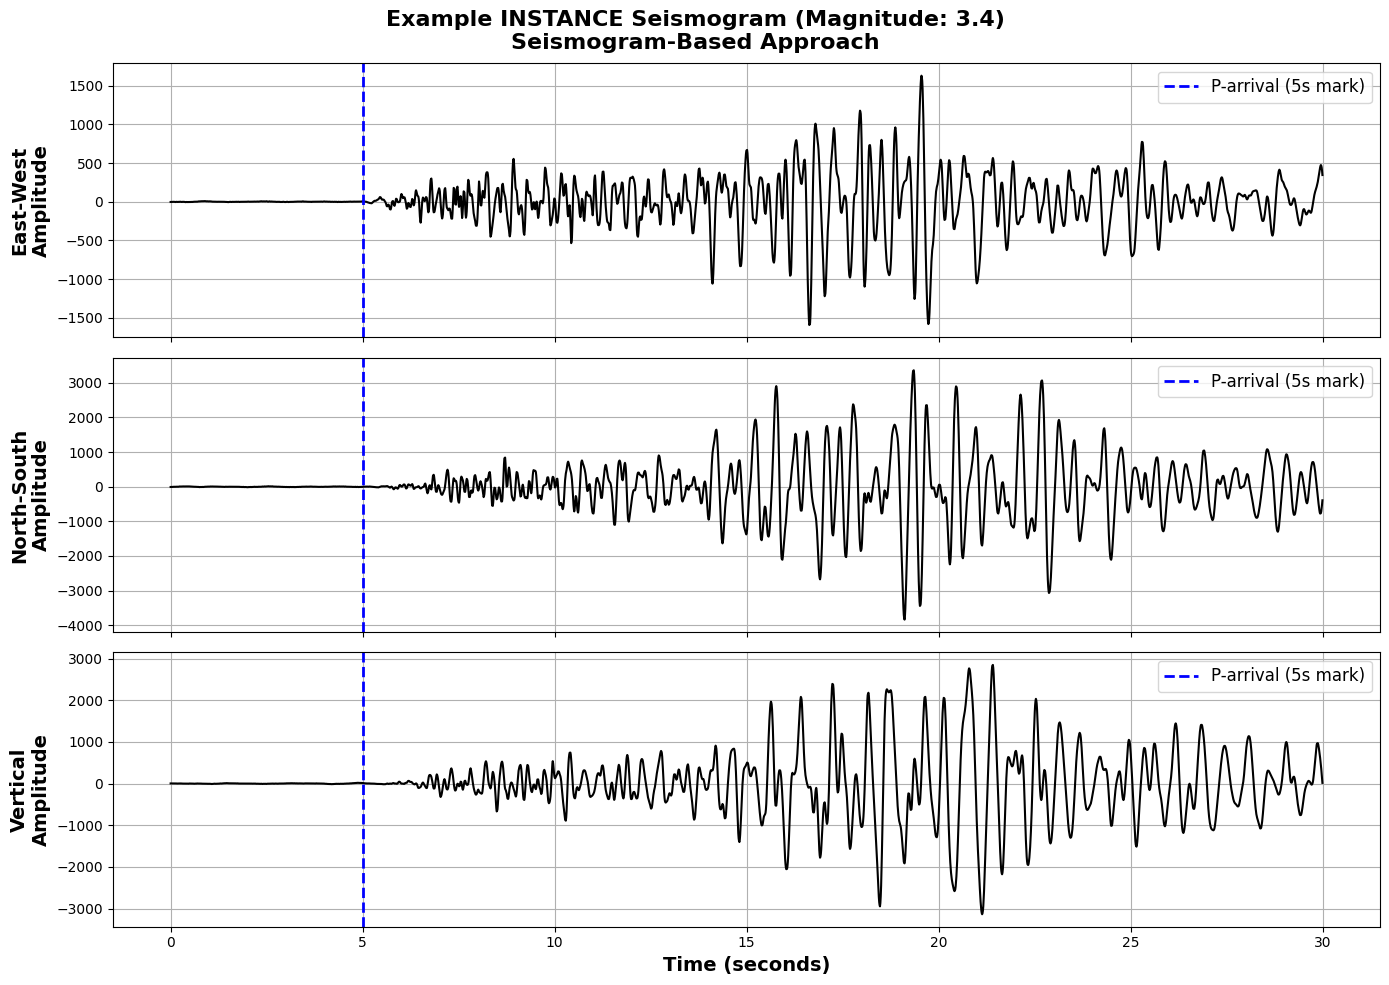


Example 501:


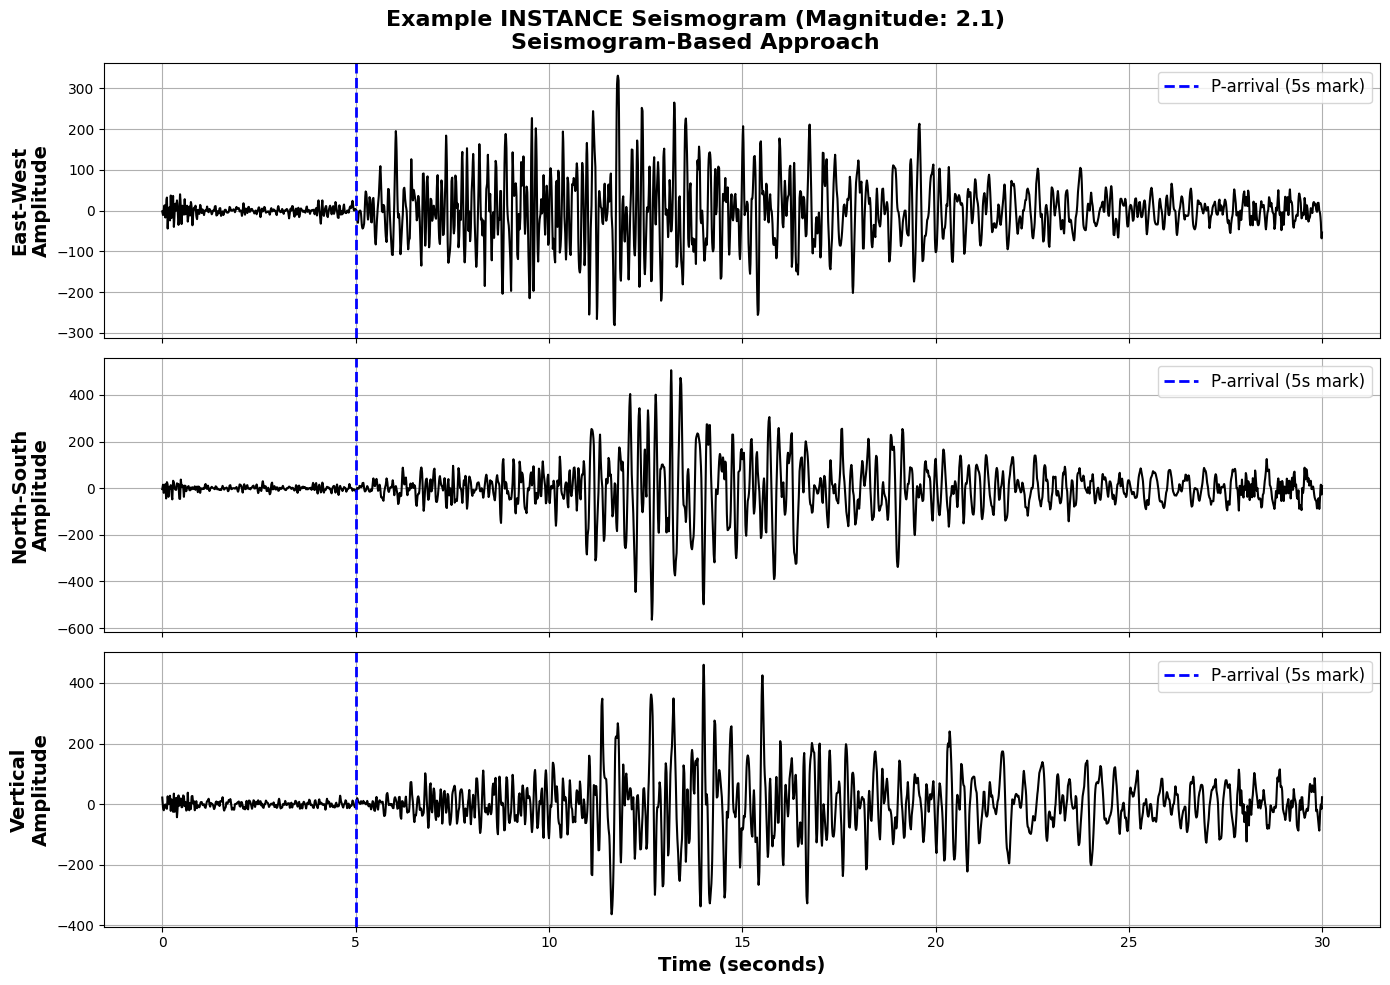

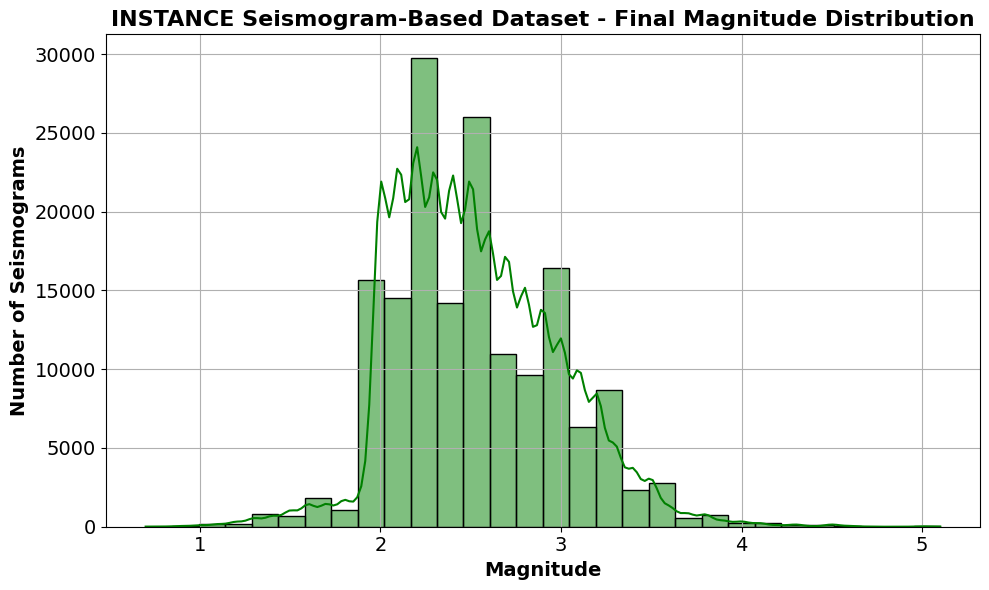

In [ ]:
"""Cell 7: Visualize Sample Seismograms"""

# Plot an example seismogram
def plot_example_seismogram_instance(data, labels, index=0):
    """Plot an example three-component seismogram"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    time = np.arange(data.shape[2]) / 100  # Convert to seconds (100Hz sampling)
    components = ['East-West', 'North-South', 'Vertical']

    for i in range(3):
        axes[i].plot(time, data[index, i, :], 'k')
        axes[i].set_ylabel(f'{components[i]}\nAmplitude', fontweight='bold', fontsize=14)
        axes[i].axvline(x=5.0, color='blue', linestyle='--', linewidth=2,
                      label='P-arrival (5s mark)')
        axes[i].grid(True)
        axes[i].legend(fontsize=12)

    axes[2].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)
    plt.suptitle(f'Example INSTANCE Seismogram (Magnitude: {labels[index]})\nSeismogram-Based Approach',
                fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot multiple example seismograms
if len(all_data) > 0:
    print("Plotting example seismograms for seismogram-based approach:")
    for i in [0, 100, 500]:  # Plot a few different examples
        if i < len(all_data):
            print(f"\nExample {i+1}:")
            plot_example_seismogram_instance(all_data, all_labels, i)

# Plot magnitude distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_labels, bins=30, kde=True, color='green')
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number of Seismograms', fontweight='bold', fontsize=14)
plt.title('INSTANCE Seismogram-Based Dataset - Final Magnitude Distribution', fontweight='bold', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Cell 8: Save Data and Create Split Information

In [ ]:
"""Cell 8: Save Data and Create Split Information"""

# Convert to tensors
all_data_tensor = torch.tensor(all_data, dtype=torch.float32)
all_labels_tensor = torch.tensor(all_labels, dtype=torch.float32)

# Save the entire dataset
print("Saving data files...")
torch.save(all_data_tensor, os.path.join(output_dir, 'all_data.pt'))
torch.save(all_labels_tensor, os.path.join(output_dir, 'all_labels.pt'))

# Create seismogram-based split information (much simpler than event-based)
def generate_seismogram_based_split_info(num_samples, train_ratio=0.7, val_ratio=0.1):
    """
    Generate split information for seismogram-based random splits

    Args:
        num_samples: Total number of seismograms
        train_ratio: Proportion for training set
        val_ratio: Proportion for validation set

    Returns:
        Dictionary with split information for random seismogram-based splits
    """
    return {
        'num_samples': num_samples,
        'train_ratio': train_ratio,
        'val_ratio': val_ratio,
        'splitting_approach': 'seismogram_based',
        'note': 'Seismograms split randomly regardless of event membership'
    }

# Generate split information
print("Preparing split information for seismogram-based experiments...")
split_info = generate_seismogram_based_split_info(len(all_data))

# Save split information
with open(os.path.join(output_dir, 'seismogram_split_info.pkl'), 'wb') as f:
    pickle.dump(split_info, f)

# Save additional metadata for comparison purposes
comparison_data = {
    'total_seismograms': len(all_data),
    'unique_events': unique_events,
    'avg_seismograms_per_event': avg_seismograms_per_event,
    'approach': 'seismogram_based',
    'potential_data_leakage': True,
    'comparison_note': 'Unlike event-based splitting, this approach may have seismograms from the same event in different splits'
}

with open(os.path.join(output_dir, 'comparison_info.pkl'), 'wb') as f:
    pickle.dump(comparison_data, f)

Saving data files...
Preparing split information for seismogram-based experiments...


Cell 9: Summary and Final Statistics

In [ ]:
"""Cell 9: Summary and Final Statistics"""

print("\n" + "="*80)
print("INSTANCE SEISMOGRAM-BASED PREPROCESSING COMPLETED")
print("="*80)

print(f"\nFiles created in the output directory:")
print(f"1. all_data.pt - All seismogram data tensors")
print(f"2. all_labels.pt - All magnitude labels")
print(f"3. seismogram_split_info.pkl - Information for random seismogram-based splits")
print(f"4. seismogram_indices.pkl - Mapping of seismogram IDs")
print(f"5. multi_observations.npy - List of stations with ≥400 observations")
print(f"6. comparison_info.pkl - Comparison data for analysis")

print(f"\nFinal Dataset Summary:")
print(f"Total seismograms: {len(all_data)}")
print(f"Unique events represented: {unique_events}")
print(f"Average seismograms per event: {avg_seismograms_per_event:.2f}")
print(f"Data shape: {all_data.shape}")

print(f"\nSplitting Approach: SEISMOGRAM-BASED")
print(f"- Seismograms will be split randomly regardless of event membership")
print(f"- This may result in seismograms from the same event appearing in different splits")
print(f"- Expected to show data leakage effects compared to event-based splitting")

# Report execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")

print(f"\nINSTANCE seismogram-based preprocessing completed successfully!")
print(f"Ready for comparison with event-based approach:")
print(f"   Event-based (10.64 seismograms/event) vs Seismogram-based (random splitting)")
print(f"Used SeisBench download - no Google Drive quota issues!")

print(f"\nNext steps:")
print(f"1. Run INSTANCE_50_Experiments_Seismogram_Based_Splits_Runs_1_to_25.ipynb")
print(f"2. Run INSTANCE_50_Experiments_Seismogram_Based_Splits_Runs_26_to_50.ipynb")
print(f"3. Compare results with event-based splitting experiments")


INSTANCE SEISMOGRAM-BASED PREPROCESSING COMPLETED

Files created in the output directory:
1. all_data.pt - All seismogram data tensors
2. all_labels.pt - All magnitude labels
3. seismogram_split_info.pkl - Information for random seismogram-based splits
4. seismogram_indices.pkl - Mapping of seismogram IDs
5. multi_observations.npy - List of stations with ≥400 observations
6. comparison_info.pkl - Comparison data for analysis

Final Dataset Summary:
Total seismograms: 164062
Unique events represented: 21760
Average seismograms per event: 7.54
Data shape: (164062, 3, 3000)

Splitting Approach: SEISMOGRAM-BASED
- Seismograms will be split randomly regardless of event membership
- This may result in seismograms from the same event appearing in different splits
- Expected to show data leakage effects compared to event-based splitting

Total execution time: 145.70 minutes

INSTANCE seismogram-based preprocessing completed successfully!
Ready for comparison with event-based approach:
   Even